<a href="https://colab.research.google.com/github/dyaccu/Hackathon2025_Proyecto3_FlightOnTime/blob/main/Validaci%C3%B3n_cruzada_estratificada_pkl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validación cruzada del modelo `modelo_FlightOnTime.pkl`

En este notebook se evalúa la **robustez del modelo final** entregado a Back-End, serializado en el archivo:

`modelo_FlightOnTime.pkl`

El objetivo es aplicar **validación cruzada estratificada (Stratified K-Fold)** para medir:

- ROC AUC (área bajo la curva ROC)
- Recall de la clase *delay* (retraso = 1)

y reportar:

- media y desviación estándar de las métricas  
- estabilidad del modelo frente a distintas particiones del dataset.


In [7]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.base import clone

sns.set_style("whitegrid")

# Opcional: silenciar warnings de versiones
import warnings
warnings.filterwarnings("ignore")


In [8]:
# Cargar el dataset base
df = pd.read_csv("/content/archivo_limpio.csv")   # ajustar nombre si fuera necesario

print("Shape del dataset:", df.shape)
display(df.head())
print("\nTipos de datos:")
print(df.dtypes)


Shape del dataset: (120000, 9)


,aerolinea,origen,destino,distancia_km,retraso,anio,mes,es_fin_semana,bloque_horario
0,IB,MAD,EZE,7652,0,2025,1,0,madrugada
1,G3,GRU,MIA,9813,1,2025,1,0,madrugada
2,AA,GRU,EZE,2447,0,2025,1,0,madrugada
3,G3,AEP,EZE,4744,1,2025,1,0,madrugada
4,G3,MAD,MIA,8372,1,2025,1,0,madrugada



Tipos de datos:
aerolinea         object
origen            object
destino           object
distancia_km       int64
retraso            int64
anio               int64
mes                int64
es_fin_semana      int64
bloque_horario    object
dtype: object


In [9]:
# Definir features y target
X = df.drop(columns=["retraso"])
y = df["retraso"]

# Importante: misma codificación que se usó al entrenar el modelo .pkl
X = pd.get_dummies(X, drop_first=True)

print("Shape de X codificado:", X.shape)
print("Cantidad de features:", X.shape[1])

print("\nDistribución de la clase 'retraso':")
print(y.value_counts(normalize=True))


Shape de X codificado: (120000, 19)
Cantidad de features: 19

Distribución de la clase 'retraso':
retraso
0    0.632325
1    0.367675
Name: proportion, dtype: float64


In [10]:
# Primer split: 80% para modelado, 20% para "datos nuevos / simulación"
X_temp, X_new, y_temp, y_new = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Segundo split: de X_temp sacamos Train y Test
# 0.375 de 0.8 ≈ 0.30 del total → mantenemos ~70/30 entre train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.375,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Test: ", X_test.shape)
print("Simulación / nuevos:", X_new.shape)


Train: (60000, 19)
Test:  (36000, 19)
Simulación / nuevos: (24000, 19)


In [11]:
# Cargar el pipeline completo desde el archivo .pkl
pipeline_original = joblib.load("/content/modelo_FlightOnTime.pkl")  # ajustar ruta si hace falta

pipeline_original


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=200,
                                            random_state=42))])

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []
recall_delay_scores = []

fold = 1
for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Clonamos el pipeline del .pkl para cada fold (evita mezclar estados)
    model_fold = clone(pipeline_original)

    # Entrenamos SOLO con los datos de train de ese fold
    model_fold.fit(X_tr, y_tr)

    # Probabilidades para ROC AUC
    probas = model_fold.predict_proba(X_val)[:, 1]

    # Predicciones para Recall
    preds = model_fold.predict(X_val)

    # Métricas
    roc_auc = roc_auc_score(y_val, probas)
    recall_delay = recall_score(y_val, preds, pos_label=1)

    roc_auc_scores.append(roc_auc)
    recall_delay_scores.append(recall_delay)

    print(f"Fold {fold}: ROC AUC = {roc_auc:.4f} - Recall Delay = {recall_delay:.4f}")
    fold += 1


Fold 1: ROC AUC = 0.8645 - Recall Delay = 0.7541
Fold 2: ROC AUC = 0.8530 - Recall Delay = 0.7344
Fold 3: ROC AUC = 0.8654 - Recall Delay = 0.7541
Fold 4: ROC AUC = 0.8573 - Recall Delay = 0.7371
Fold 5: ROC AUC = 0.8611 - Recall Delay = 0.7460


In [13]:
print("\n=== RESULTADOS FINALES ===")
print(f"ROC AUC - Mean: {np.mean(roc_auc_scores):.4f} | Std: {np.std(roc_auc_scores):.4f}")
print(f"Recall (delay=1) - Mean: {np.mean(recall_delay_scores):.4f} | Std: {np.std(recall_delay_scores):.4f}")

# DataFrame con resultados por fold
df_cv = pd.DataFrame({
    "Fold": range(1, len(roc_auc_scores)+1),
    "ROC_AUC": roc_auc_scores,
    "Recall_delay": recall_delay_scores
})

df_cv



=== RESULTADOS FINALES ===
ROC AUC - Mean: 0.8603 | Std: 0.0046
Recall (delay=1) - Mean: 0.7451 | Std: 0.0083


,Fold,ROC_AUC,Recall_delay
0,1,0.864515,0.754080
1,2,0.852953,0.734361
2,3,0.865423,0.754080
3,4,0.857284,0.737081
4,5,0.861101,0.745978


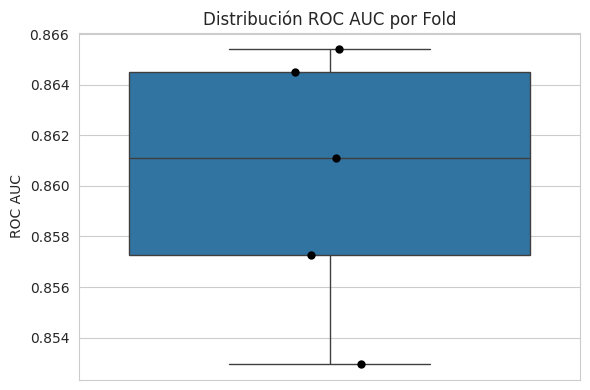

In [14]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df_cv["ROC_AUC"])
sns.stripplot(y=df_cv["ROC_AUC"], color="black", size=6)
plt.title("Distribución ROC AUC por Fold")
plt.ylabel("ROC AUC")
plt.tight_layout()
plt.show()


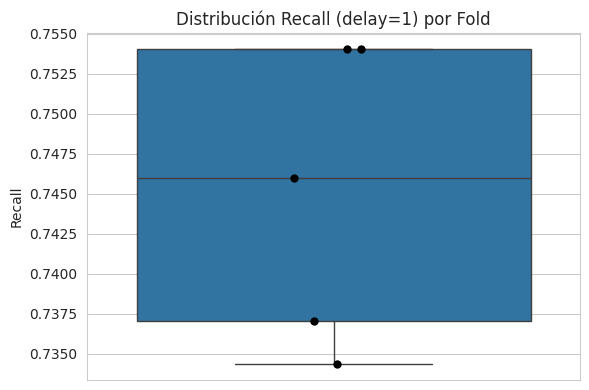

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df_cv["Recall_delay"])
sns.stripplot(y=df_cv["Recall_delay"], color="black", size=6)
plt.title("Distribución Recall (delay=1) por Fold")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()


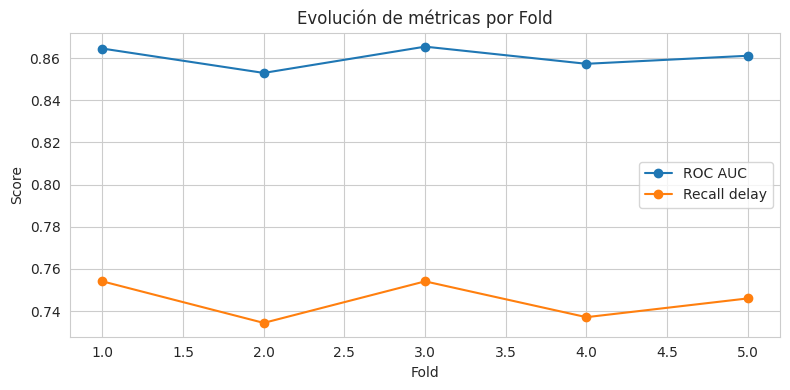

In [16]:
plt.figure(figsize=(8,4))
plt.plot(df_cv["Fold"], df_cv["ROC_AUC"], marker="o", label="ROC AUC")
plt.plot(df_cv["Fold"], df_cv["Recall_delay"], marker="o", label="Recall delay")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Evolución de métricas por Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🧠 Insight Final – Validación Cruzada del modelo `FlightOnTime.pkl`

La validación cruzada estratificada (Stratified K-Fold con 5 folds) aplicada sobre el modelo final confirma que el modelo es **estable, robusto y generaliza correctamente** a nuevas particiones del conjunto de entrenamiento.

---

### 📌 Resultados por fold

| Fold | ROC AUC | Recall Delay |
|------|---------|--------------|
| 1 | 0.8645 | 0.7541 |
| 2 | 0.8530 | 0.7344 |
| 3 | 0.8654 | 0.7541 |
| 4 | 0.8573 | 0.7371 |
| 5 | 0.8611 | 0.7459 |

---

### 📊 Métricas agregadas

- **ROC AUC (media): 0.8603**  
- **ROC AUC (desvío estándar): 0.0046**

- **Recall delay=1 (media): 0.7451**  
- **Recall delay=1 (desvío estándar): 0.0083**

Estas métricas muestran una variabilidad mínima entre folds, lo cual indica que el modelo es consistente independientemente de cómo se dividan los datos.

---

### ✔️ Interpretación de los resultados

#### 1️⃣ Estabilidad del modelo
El ROC AUC mantiene valores muy parecidos en todos los folds, entre **0.853 y 0.865**, y la desviación estándar es extremadamente baja.  
Esto refleja que el modelo:

- generaliza bien,
- no depende de una partición específica,
- no muestra signos de sobreajuste.

Los boxplots confirman una distribución compacta sin outliers.

---

#### 2️⃣ Recall de la clase retraso
El recall se mantiene estable alrededor del **74–75%**, lo que significa que:

> El modelo detecta correctamente aproximadamente el 75% de los vuelos que realmente se retrasan.

Este comportamiento es importante para el negocio, ya que minimizar falsos negativos reduce riesgo operativo y mejora la experiencia del usuario.

---

#### 3️⃣ Comportamiento visual
Los gráficos de líneas muestran curvas suaves tanto para ROC AUC como para Recall, sin saltos bruscos entre folds.  
Esto confirma la **consistencia y estabilidad inter-fold** del modelo.

---

### 🏁 Conclusión final

El modelo `FlightOnTime.pkl` es **robusto y apto para producción**, ya que:

- mantiene métricas estables en diferentes particiones,
- no muestra sobreajuste,
- logra un buen equilibrio entre discriminación (ROC AUC alto) y detección de retrasos (Recall elevado),
- ofrece predicciones confiables que pueden integrarse directamente en la API de backend.

Esto valida su uso dentro del MVP de FlightOnTime para predecir retrasos de vuelos en tiempo real.

---
